# Description

Somewhat cleaner notebook for exploring learning IVs, in the linear case.

# Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import seaborn as sns

from ipywidgets import interact_manual, IntSlider, FloatSlider
from sklearn.linear_model import LinearRegression
from linearmodels.iv.model import IV2SLS

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm

In [14]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from econml.grf import RegressionForest

In [3]:
%load_ext autoreload
%autoreload 2

# Setup: linear treatment effects

We take a classic linear regression setup, where the treatment is correlated with some confounder $C$:

$$
Y = \beta + \tau T + \gamma C + \epsilon, \;\; Cov(T,C) \neq 0
$$

The estimand of interest is $\tau$, the treatment effect.

We then have an instrumental variable $Z$ such that:

$$
T = \pi Z + \psi C + \eta, \;\; Cov(Z,C) = 0
$$

In [4]:
def generate_const_linear_iv(
    n_samples,
    seed,
    pi,
    psi,
    tau,
    gamma
):
    """
    Generates linear IV with constant treatment effects.
    
    Args:
        n_samples (int): num samples to generate
        seed (int): seed for reproducibilty
        pi (float): instrument "strength"
        psi (float): confounding "strength"
        tau (float): treatment effect
        gamma (float): confound effect
    
    Returns:
        pd.DataFrame
    """
    np.random.seed(seed),
    Z = np.random.normal(0, 1, size=n_samples)#np.random.uniform(0, 10, n_samples)
    C = np.random.normal(0, 1, size=n_samples)#np.random.uniform(0, 10, n_samples)
    eta = np.random.normal(0, 1, size=n_samples)
    const = np.random.uniform(-1, 1)

    T = const + (pi*Z) + (psi*C) + eta

    epsilon = np.random.normal(0, 1, size=n_samples)
    beta = np.random.uniform(-1, 1)

    Y = beta + (tau*T) + (gamma*C) + epsilon

    data = np.concatenate([Z.reshape(-1,1), 
                           C.reshape(-1,1), 
                           T.reshape(-1,1),
                           Y.reshape(-1,1),], 
                         axis=1)

    data_df = pd.DataFrame(data, columns=['Z', 'C', 'T', 'Y'])

    return data_df


In [5]:
# generate IV data

# consts
n_samples = 1000
seed = 42
pi = 1 # IV "strength"
psi = 5 # confound "strength"

tau = 2 # treat effect
gamma = -5 # confound effect

df = generate_const_linear_iv(
        n_samples,
        seed,
        pi,
        psi,
        tau,
        gamma)

df

Z         C         T         Y
0    0.496714  1.399355  7.455794  8.165450
1   -0.138264  0.924634  4.977866  6.099834
2    0.647689  0.059630  0.790901  1.169550
3    1.523030 -0.646937 -1.382135  0.640969
4   -0.234153  0.698223  2.000829  0.956657
..        ...       ...       ...       ...
995 -0.281100  1.070150  5.784612  6.625270
996  1.797687 -0.026521  2.560313  5.047941
997  0.640843 -0.881875 -4.372811 -3.512755
998 -0.571179 -0.163067 -0.414857  0.175355
999  0.572583 -0.744903 -2.669709 -2.124274

[1000 rows x 4 columns]

(-10.0, 10.0)

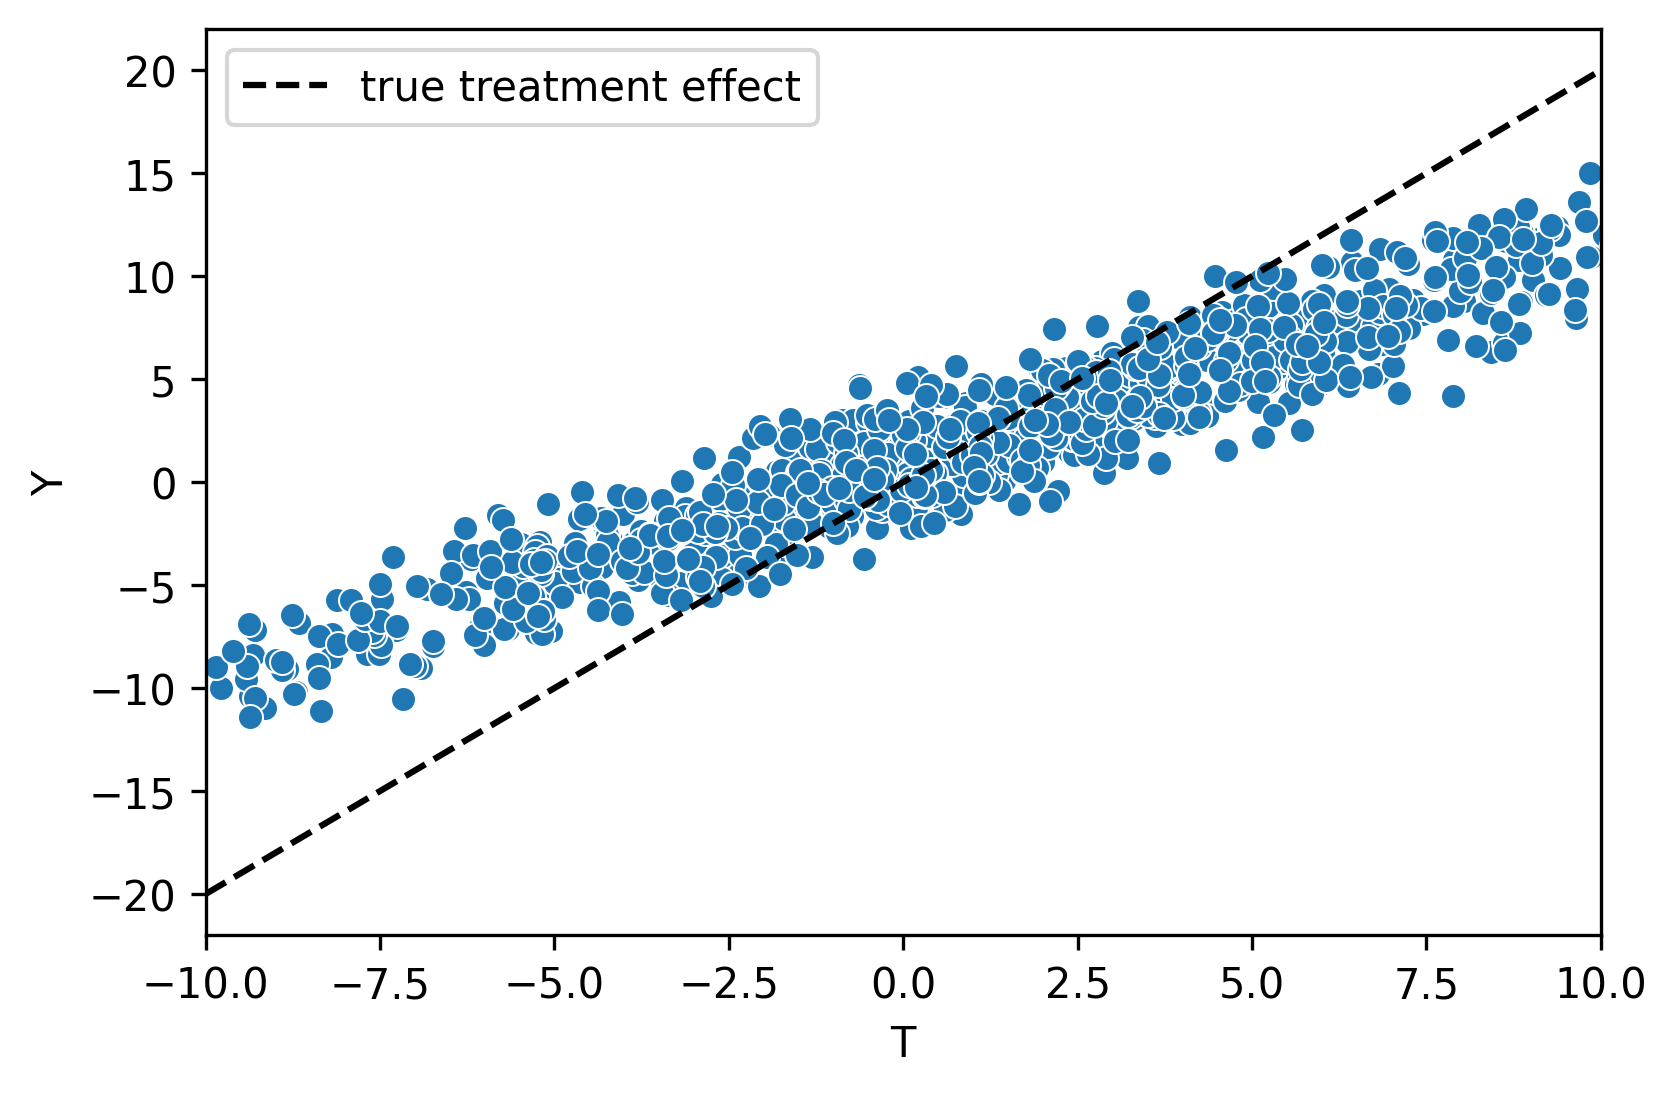

In [117]:
fig, ax = plt.subplots()
fig.patch.set_facecolor("white")
ax.plot(np.linspace(-10,10, 20), 2*np.linspace(-10,10,20), ls='--', color='black', label="true treatment effect")
sns.scatterplot(x='T', y='Y', data=df, ax=ax)
ax.set_xlim(-10,10)

In [21]:
feat_cols = [
    "mean_Z",
    "mean_T",
    "mean_Y",
    "var_Z",
    "var_T",
    "var_Y",
    "cov_ZT",
    "cov_ZY",
    "cov_TY",
    "n"
]

def generate_iv_features(data_df, confounder='C'):
    """Generates IV features from a given simple (four variable) data matrix."""
    
    data = data_df.drop(confounder, axis='columns', errors='ignore')   
    data = data[["Z", "T", "Y"]]
    
    cov_mat = np.cov(data, rowvar=False)

    var = np.diag(cov_mat).reshape(-1)
    var = var[var != 0]
    
    cov = np.array([cov_mat[0,1], cov_mat[0,2], cov_mat[1,2]])
    mean = np.mean(data).values

    feats = np.concatenate([mean, var, cov, np.array(data_df.shape[0]).reshape(-1)])

    return pd.DataFrame(feats.reshape(1, -1), columns=feat_cols)

In [22]:
feat_df = generate_iv_features(df)

## Full simulations: varying IV strength

In [64]:
iv_strs = np.round(np.linspace(.2, 2, 10), 2) 

### Regression, TSLS 

In [118]:
n_datasets = 10000
n_test_datasets = 2000

#n_samples = 1000
psi = 5 # confound "strength"

iv_mses = []
reg_mses = []

iv_stderrs = []
iv_preds = []
reg_preds = []

reg_bias = []
reg_vars = []

iv_bias = []
iv_vars = []

for pi in tqdm(iv_strs):
    print(pi)
    lin_reg_taus = np.zeros(n_test_datasets)
    tsls_taus = np.zeros(n_test_datasets)
    tsls_stderrs = np.zeros(n_test_datasets)
    test_taus = np.zeros(n_test_datasets)

    for i in range(n_test_datasets):
        seed = i + int(pi*10000) # to ensure we have non-overlapping datasets
        
        treat_effect = np.random.uniform(-2, 2)
        confound_effect = np.random.uniform(1, 5)
        n_samples = 1000
        #n_samples = int(np.random.uniform(500, 5000))
        
        data_df = generate_const_linear_iv(
            n_samples=n_samples,
            seed=seed,
            pi=pi,
            psi=psi,
            tau=treat_effect,
            gamma=confound_effect)
        
        lin_reg = LinearRegression()

        lin_reg.fit(data_df['T'].values.reshape(-1,1), data_df['Y'])
        tsls = IV2SLS.from_formula('Y ~ 1 + [T ~ Z]',
                                   data=data_df)    
        iv_res = tsls.fit()
        
        lin_reg_taus[i] = lin_reg.coef_[0]
        tsls_taus[i] = iv_res.params['T']
        tsls_stderrs[i] = iv_res.std_errors['T']
        


        test_taus[i] = treat_effect
        #break
        
    tsls_bias = np.mean((test_taus - np.mean(tsls_taus)) ** 2)
    tsls_var = np.var(tsls_taus)
    
    lin_reg_bias = np.mean((test_taus - np.mean(lin_reg_taus)) ** 2)
    lin_reg_var = np.var(lin_reg_taus)
    
    reg_bias.append(lin_reg_bias)
    reg_vars.append(lin_reg_var)

    iv_bias.append(tsls_bias)
    iv_vars.append(tsls_var)
    
    iv_preds.append(tsls_taus)
    iv_stderrs.append(tsls_stderrs)
    reg_preds.append(lin_reg_taus)
        
    iv_mses.append(mse(tsls_taus, test_taus))
    reg_mses.append(mse(lin_reg_taus, test_taus))
    #break

  0%|          | 0/10 [00:00<?, ?it/s]

0.2


 10%|█         | 1/10 [00:20<03:01, 20.11s/it]

0.4


 20%|██        | 2/10 [00:40<02:40, 20.10s/it]

0.6


 30%|███       | 3/10 [01:00<02:20, 20.11s/it]

0.8


 40%|████      | 4/10 [01:20<02:01, 20.22s/it]

1.0


 50%|█████     | 5/10 [01:40<01:41, 20.20s/it]

1.2


 60%|██████    | 6/10 [02:01<01:20, 20.19s/it]

1.4


 70%|███████   | 7/10 [02:21<01:00, 20.25s/it]

1.6


 80%|████████  | 8/10 [02:41<00:40, 20.23s/it]

1.8


 90%|█████████ | 9/10 [03:01<00:20, 20.21s/it]

2.0


100%|██████████| 10/10 [03:22<00:00, 20.22s/it]


In [119]:
reg_mses

[0.3819241002556736,
 0.37699140178044,
 0.37124062438348715,
 0.3617092357135151,
 0.35944525264113375,
 0.3339468130476066,
 0.3250928725025491,
 0.31696905059952346,
 0.2998518794039199,
 0.28901504230713193]

In [120]:
iv_mses

[48.98939784943602,
 15.505046816571557,
 3.4484049564709243,
 0.027546577311709064,
 0.015214074210619351,
 0.009640863985447189,
 0.006727351601334576,
 0.004460753894411381,
 0.003558966233166242,
 0.0029926692099676443]

### Features for supervised learning

In [121]:
ml_mses = []
ml_preds = []

wald_preds = []
wald_mses = []

test_taus = []
test_feats = []
test_stderrs = []
feat_importances = []

n_datasets = 10000
n_test_datasets = 2000

for pi in tqdm(iv_strs):
    data = np.zeros((n_datasets, 10))
    taus = np.zeros(n_datasets)
    confounds = np.zeros(n_datasets)
    
    for i in range(n_datasets):
        seed = i + int(pi*10000) # to ensure we have non-overlapping datasets
        
        treat_effect = np.random.uniform(-2, 2)
        confound_effect = np.random.uniform(1, 5)
        n_samples = 1000
        
        data_df = generate_const_linear_iv(
            n_samples=n_samples,
            seed=seed,
            pi=pi,
            psi=psi,
            tau=treat_effect,
            gamma=confound_effect)
        
        feats = generate_iv_features(data_df)
        data[i,:] = feats
        taus[i] = treat_effect
        confounds[i] = confound_effect
        
    X_train = data[n_test_datasets:, :]
    X_test = data[:n_test_datasets, :]

    y_train = taus[n_test_datasets:]
    y_test = taus[:n_test_datasets]
    
    meta_learner = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=8)
    #RegressionForest(random_state=42, n_estimators=100)
    meta_learner.fit(X_train, y_train)
    
    preds = meta_learner.predict(X_test)
    #std_err = meta_learner.prediction_stderr(X_test)
    
    #        Cov(Z,Y)       Cov(T,Z)
    wald = X_test[:, 7] / X_test[:, 6]
    wald_preds.append(wald)
    
    ml_preds.append(preds)
    test_taus.append(y_test)
    test_feats.append(X_test)
    #test_stderrs.append(std_err)
    
    feat_importances.append(meta_learner.feature_importances_)
    ml_mses.append(mse(preds, y_test))
    wald_mses.append(mse(wald, y_test))

100%|██████████| 10/10 [03:23<00:00, 20.40s/it]


In [122]:
len(feat_importances)

10

(4, 3)


Text(0.5, 0.98, 'Covariance plots against estimated tau for IV str 0.2')

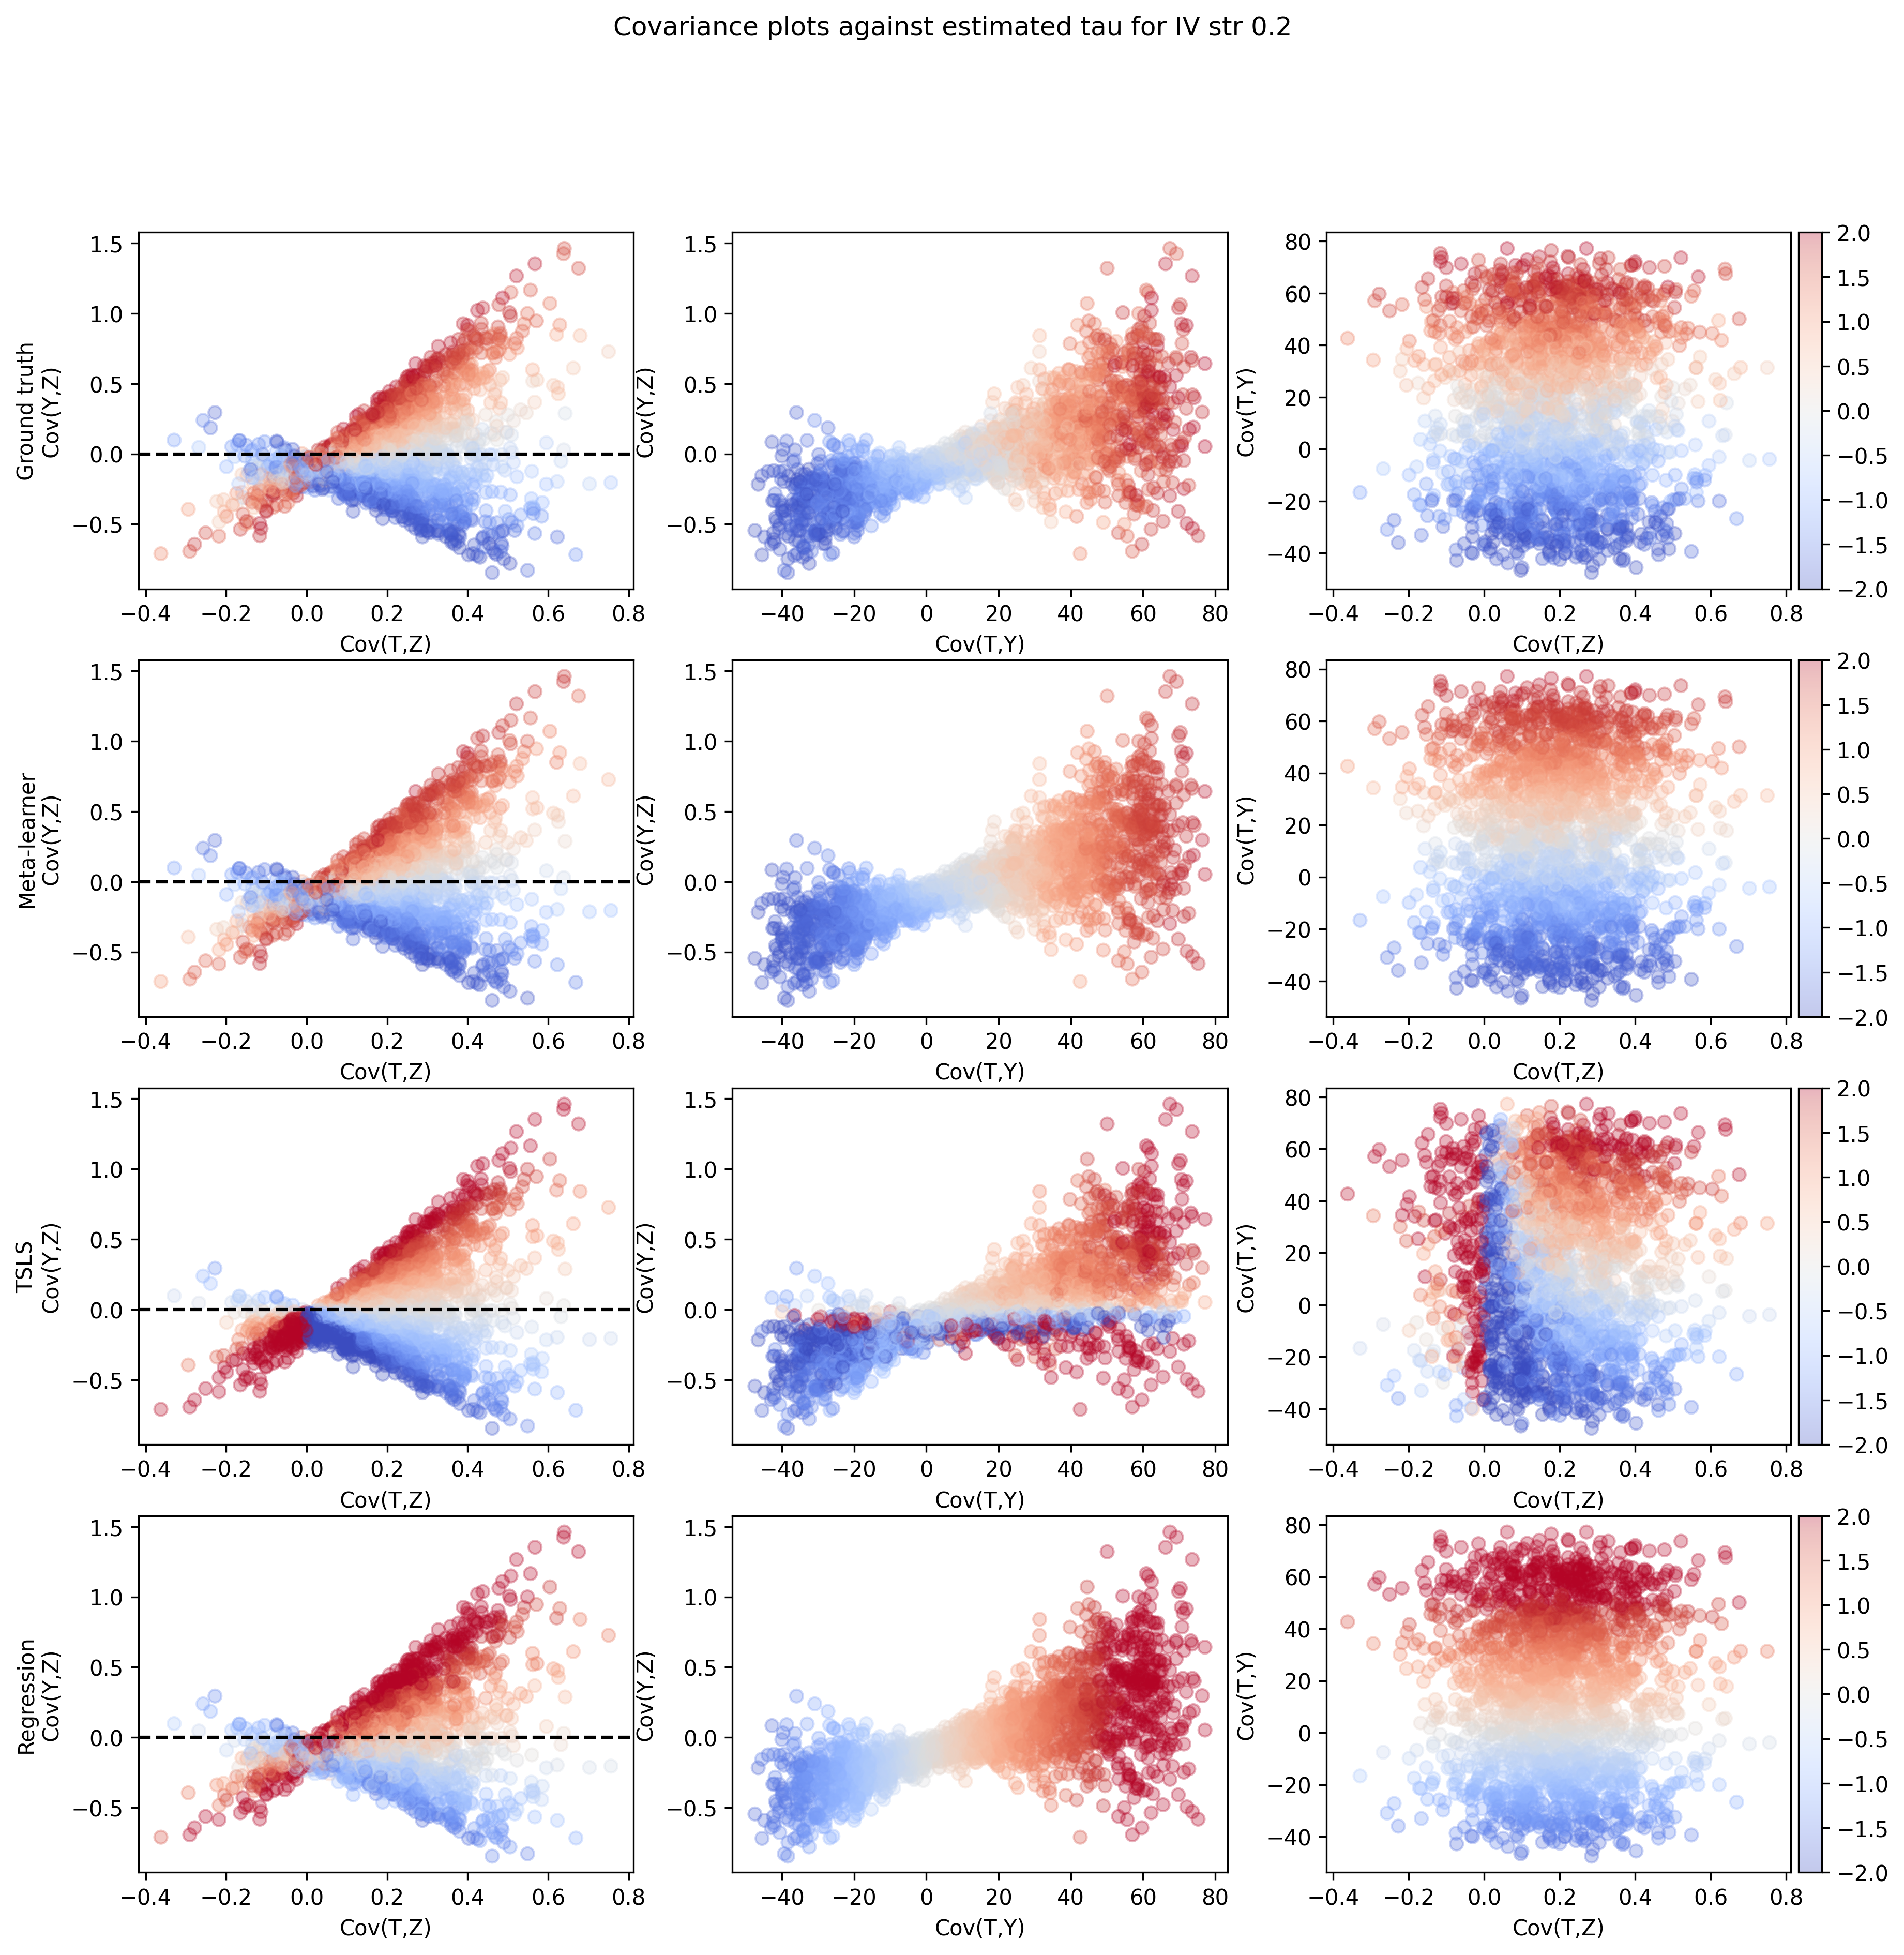

In [123]:
fig, axs = plt.subplots(4, 3, figsize=(14, 14), dpi=300)
fig.patch.set_color("white")
print(axs.shape)

COV_TY = 8
COV_YZ = 7
COV_TZ = 6

idx = 0

X_test = test_feats[idx]

# ground truth
ax1, ax2, ax3 = axs[0]
y = test_taus[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Ground truth\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# ml
ax1, ax2, ax3 = axs[1]
y = ml_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Meta-learner\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# tsls
ax1, ax2, ax3 = axs[2]
y = iv_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("TSLS\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")
ax1.axhline(y=0, ls='--', color='black')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')

# reg
ax1, ax2, ax3 = axs[3]
y = reg_preds[idx]
sc = ax1.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax1.set_xlabel("Cov(T,Z)")
ax1.set_ylabel("Regression\nCov(Y,Z)")
sc = ax2.scatter(x=X_test[:,COV_TY], y=X_test[:, COV_YZ], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax2.set_xlabel("Cov(T,Y)")
ax2.set_ylabel("Cov(Y,Z)")
sc = ax3.scatter(x=X_test[:,COV_TZ], y=X_test[:, COV_TY], c=y, cmap='coolwarm', alpha=0.3, vmin=-2, vmax=2)
ax3.set_xlabel("Cov(T,Z)")
ax3.set_ylabel("Cov(T,Y)")

ax1.axhline(y=0, ls='--', color='black')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc, cax=cax, orientation='vertical')
plt.suptitle("Covariance plots against estimated tau for IV str {}".format(iv_strs[idx]))

Text(0.5, 1.0, 'MSE for n=2000, confounded treatment, 10k datasets')

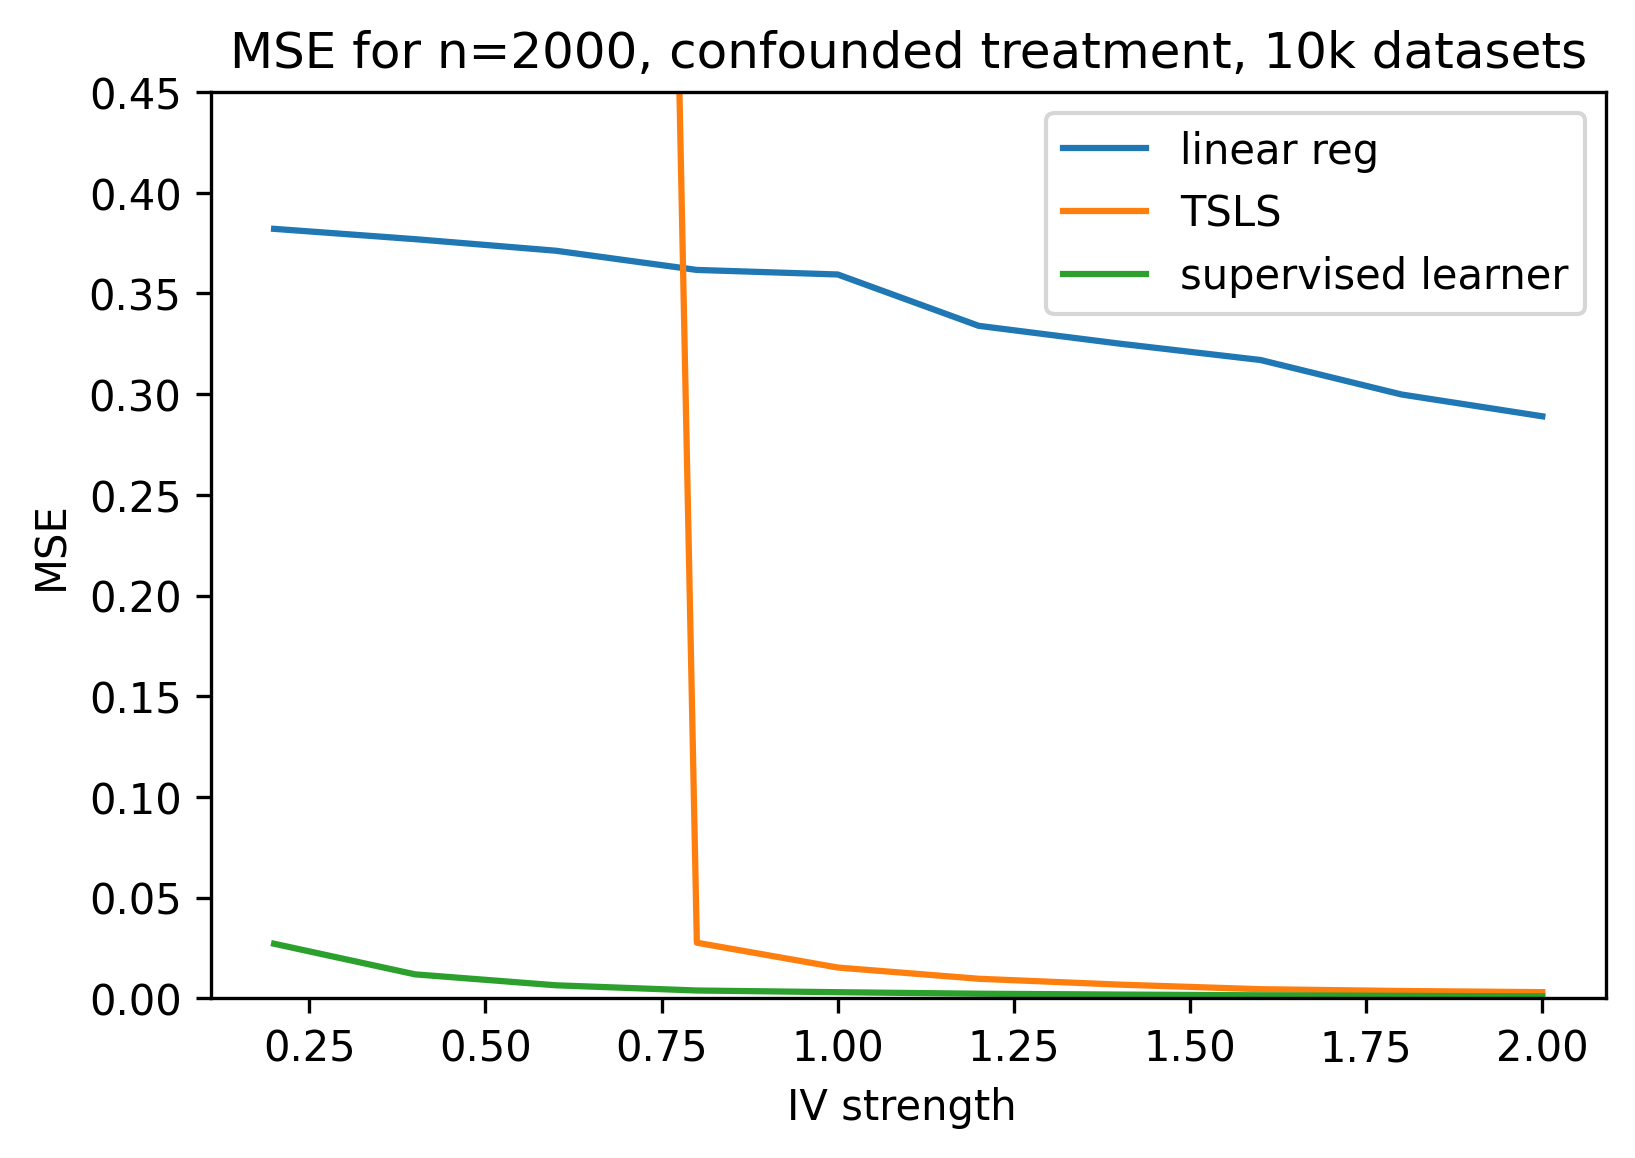

In [72]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_color("white")

ax.plot(iv_strs, reg_mses, label="linear reg")
ax.plot(iv_strs, iv_mses, label="TSLS")
ax.plot(iv_strs, ml_mses, label="supervised learner")
#ax.plot(iv_strs, wald_mses, label="Cov(Y,Z) / Cov(T,Z)")
ax.legend()
ax.set_ylim(0, 0.45)
ax.set_ylabel("MSE")
ax.set_xlabel("IV strength ")
ax.set_title("MSE for n=2000, confounded treatment, 10k datasets")

In [73]:
feat_array = np.array(feat_importances)

Text(0.5, 1.0, 'Feature importances for n=1000, confounded treatment, 10k datasets')

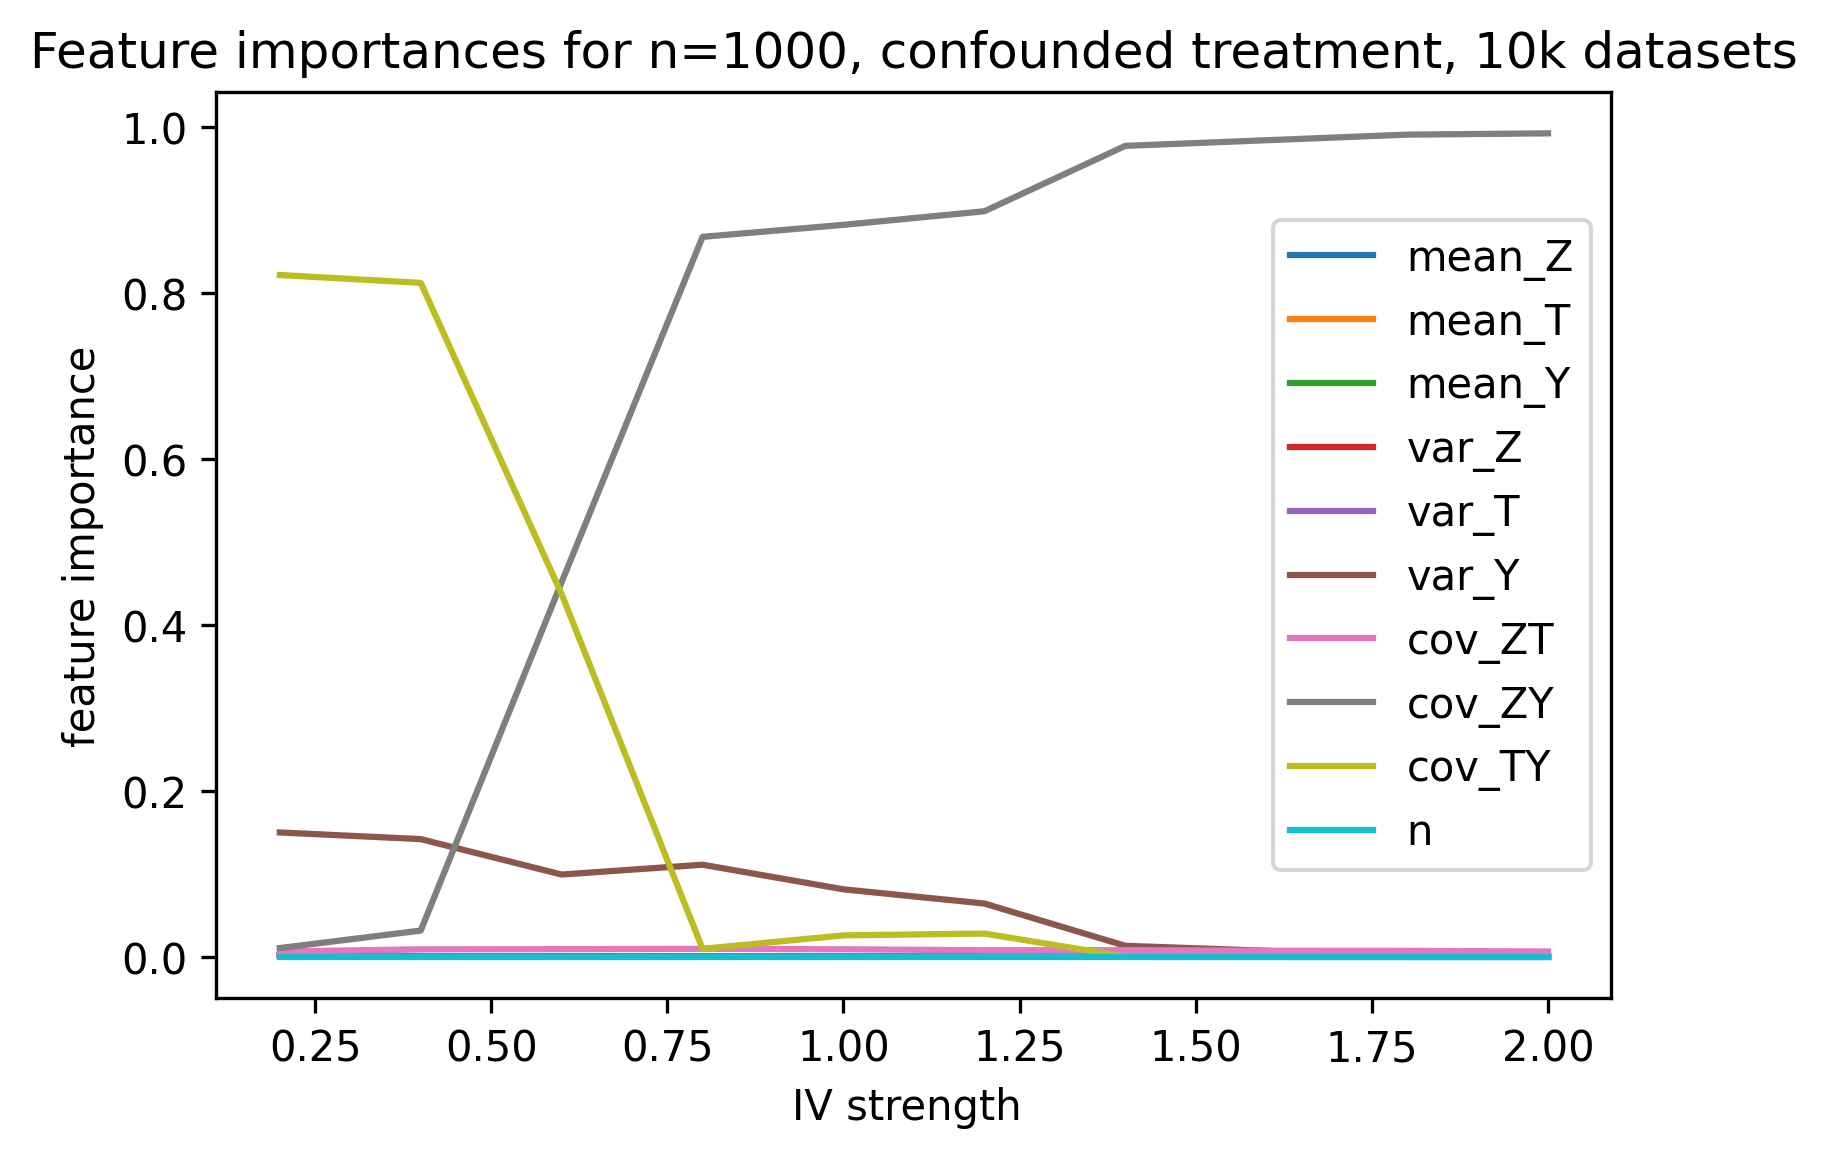

In [74]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_color("white")

for i in range(10):
    ax.plot(iv_strs, feat_array[:, i], label=feat_cols[i])
ax.legend()
#ax.set_ylim(0, 1)
ax.set_ylabel("feature importance")
ax.set_xlabel("IV strength ")
ax.set_title("Feature importances for n=1000, confounded treatment, 10k datasets")

# Bias-variance decomp sandbox

In [49]:
from mlxtend.evaluate import bias_variance_decomp

In [93]:
ml_mses = []
ml_preds = []

ml_bias = []
ml_vars = []
ml_avg_loss = []
ml_noise = []

wald_preds = []
wald_mses = []

test_taus = []
test_feats = []
test_stderrs = []
feat_importances = []

n_datasets = 10000
n_test_datasets = 2000

for pi in tqdm(iv_strs):
    data = np.zeros((n_datasets, 10))
    taus = np.zeros(n_datasets)
    confounds = np.zeros(n_datasets)
    
    for i in range(n_datasets):
        seed = i + int(pi*10000) # to ensure we have non-overlapping datasets
        
        treat_effect = np.random.uniform(-2, 2)
        confound_effect = np.random.uniform(1, 5)
        n_samples = 1000
        
        data_df = generate_const_linear_iv(
            n_samples=n_samples,
            seed=seed,
            pi=pi,
            psi=psi,
            tau=treat_effect,
            gamma=confound_effect)
        
        feats = generate_iv_features(data_df)
        data[i,:] = feats
        taus[i] = treat_effect
        confounds[i] = confound_effect
        
    X_train = data[n_test_datasets:, :]
    X_test = data[:n_test_datasets, :]

    y_train = taus[n_test_datasets:]
    y_test = taus[:n_test_datasets]
    
    print(X_test.shape)
    print(y_test.shape)
    
    meta_learner = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=12)
    #RegressionForest(random_state=42, n_estimators=100)
    
    # bias variance decomp
    #     avg_mse, avg_bias, avg_var = bias_variance_decomp(meta_learner, X_train, y_train, X_test, y_test.reshape(-1,1), 
    #                                                       random_seed=42, loss='mse', num_rounds=100)
    #     ml_bias.append(avg_bias)
    #     ml_vars.append(avg_var)
    #     ml_avg_loss.append(avg_mse)
    

    
    
    meta_learner.fit(X_train, y_train)
    
    preds = meta_learner.predict(X_test)
    
    y_noise = np.var(y_test)
    y_bias = np.mean((y_test - np.mean(preds)) ** 2)
    y_var = np.var(preds)
    
    ml_bias.append(y_bias)
    ml_vars.append(y_var)
    ml_noise.append(y_noise)
    
    #std_err = meta_learner.prediction_stderr(X_test)
    
    #        Cov(Z,Y)       Cov(T,Z)
    wald = X_test[:, 7] / X_test[:, 6]
    wald_preds.append(wald)
    
    ml_preds.append(preds)
    test_taus.append(y_test)
    test_feats.append(X_test)
    #test_stderrs.append(std_err)
    
    feat_importances.append(meta_learner.feature_importances_)
    ml_mses.append(mse(preds, y_test))
    wald_mses.append(mse(wald, y_test))
    


  0%|          | 0/10 [00:00<?, ?it/s]

(2000, 10)
(2000,)


 10%|█         | 1/10 [00:20<03:00, 20.02s/it]

(2000, 10)
(2000,)


 20%|██        | 2/10 [00:39<02:39, 19.93s/it]

(2000, 10)
(2000,)


 30%|███       | 3/10 [00:59<02:19, 19.96s/it]

(2000, 10)
(2000,)


 40%|████      | 4/10 [01:19<01:59, 19.96s/it]

(2000, 10)
(2000,)


 50%|█████     | 5/10 [01:39<01:39, 19.97s/it]

(2000, 10)
(2000,)


 60%|██████    | 6/10 [01:59<01:20, 20.01s/it]

(2000, 10)
(2000,)


 70%|███████   | 7/10 [02:19<01:00, 20.03s/it]

(2000, 10)
(2000,)


 80%|████████  | 8/10 [02:39<00:40, 20.01s/it]

(2000, 10)
(2000,)


 90%|█████████ | 9/10 [02:59<00:20, 20.02s/it]

(2000, 10)
(2000,)


100%|██████████| 10/10 [03:19<00:00, 20.00s/it]


Text(0.5, 1.0, 'bias/variance for n=2000, confounded treatment, 10k datasets')

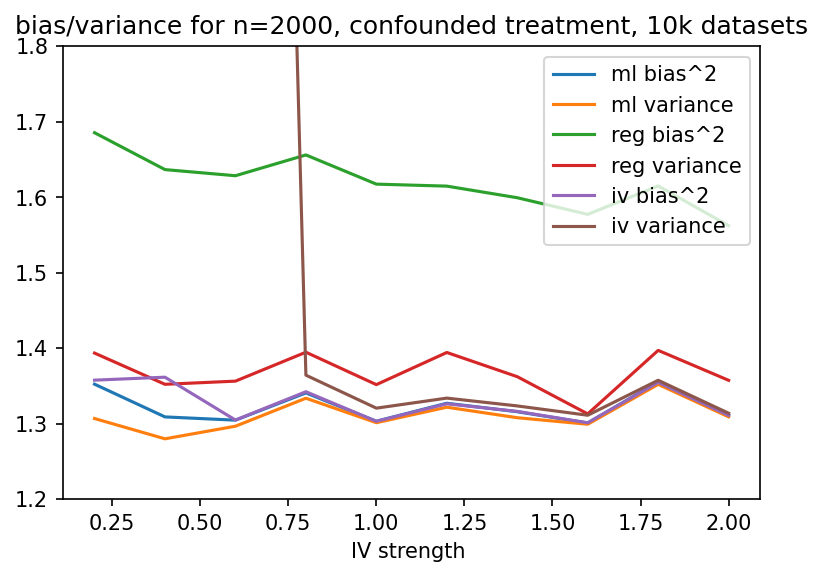

In [113]:
fig, ax = plt.subplots(dpi=150)
fig.patch.set_color("white")

ax.plot(iv_strs, ml_bias, label="ml bias^2")
ax.plot(iv_strs, ml_vars, label="ml variance")
ax.plot(iv_strs, reg_bias, label="reg bias^2")
ax.plot(iv_strs, reg_vars, label="reg variance")
ax.plot(iv_strs, iv_bias, label="iv bias^2")
ax.plot(iv_strs, iv_vars, label="iv variance")
#ax.plot(iv_strs, ml_noise, label="noise")
#ax.plot(iv_strs, wald_mses, label="Cov(Y,Z) / Cov(T,Z)")
ax.legend(loc="upper right")
ax.set_ylim(1.2, 1.8)
ax.set_ylabel("")
ax.set_xlabel("IV strength ")
ax.set_title("bias/variance for n=2000, confounded treatment, 10k datasets")

## Test on flu data

In [ ]:
%%time
data = np.zeros((n_datasets, 10))
taus = np.zeros(n_datasets)
confounds = np.zeros(n_datasets)

pi = 0.5

for i in tqdm(range(n_datasets)):
    seed = i + int(pi*10000) # to ensure we have non-overlapping datasets

    treat_effect = np.random.uniform(-2, 2)
    confound_effect = np.random.uniform(1, 5)
    n_samples = int(np.random.uniform(500, 5000))
    pi = np.random.uniform(0, 2)
    #n_samples = 1000

    data_df = generate_const_linear_iv(
        n_samples=n_samples,
        seed=seed,
        pi=pi,
        psi=psi,
        tau=treat_effect,
        gamma=confound_effect)

    feats = generate_iv_features(data_df)
    data[i,:] = feats
    taus[i] = treat_effect
    confounds[i] = confound_effect

X_train = data[n_test_datasets:, :]
X_test = data[:n_test_datasets, :]

y_train = taus[n_test_datasets:]
y_test = taus[:n_test_datasets]



In [ ]:
%%time
meta_learner = RegressionForest(random_state=42, n_estimators=100)
meta_learner.fit(X_train, y_train)
preds = meta_learner.predict(X_test)

mse(preds, y_test)

In [ ]:
flu_df = pd.read_stata("../data/flu_clean.dta")

In [ ]:
flu_df.head()

In [ ]:
sel_df = flu_df[flu_df['female'] == 1][['assign', 'receive', 'outcome']]
#sel_df = flu_df[['assign', 'receive', 'outcome']]

In [ ]:
sel_df = sel_df.rename({
    'assign': 'Z',
    'receive': 'T',
    'outcome': 'Y'
}, axis='columns')

In [ ]:
flu_feats = generate_iv_features(sel_df)

In [ ]:
flu_feats

In [ ]:
meta_learner.predict(flu_feats)

In [ ]:
meta_learner.predict_interval(flu_feats)

In [ ]:
meta_learner.prediction_stderr(flu_feats)

# Setup: LATE

**TODO**